## Preparation

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models.detection import faster_rcnn, fasterrcnn_resnet50_fpn_v2

import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
sys.path.append('../src')
from utils import pred_eval
from model import CRNN

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device}')

max_object_line = 50
max_object_char = 40
num_classes_line = 3
num_classes_char = 6000

line_size = (384, 24)
object_size_range = (12, 32)

nc = 1
nh = 384
nclass = num_classes_char + 1
height = line_size[1]

batch_size = 32
train_ratio = 0.9
vertical_ratio = 0.9
data_num = 10000
base_num_epochs = 0
num_epochs = 500
learning_rate = 0.001

max_blank_prob = 0.2
rotation_range = 1
intensity_shift_threshold = 128
intensity_shift_range = (-75, 75)
line_noise_range = (128, 255)
max_base_noise_amount = 20
max_line_noise_ratio = 0.1
max_white_noise_ratio = 0.1
max_sp_noise_ratio = 0.05

transform = True
frequency = True
word_replace = True
word_replace_prob = 0.25

dataset_path = "../data/train_6k"
character_source = "../data/source/CCL6kT.txt"
character_freq = "../data/source/CCL6k_freq.txt"
word_source = "../data/source/words.txt"
model_path_line = '../models/frcnnv2_det_50_mixed.pth'

model_path_load = f'../models/crnn_rec_{num_classes_char}_{base_num_epochs}.pth'
model_path_save = f'../models/crnn_rec_{num_classes_char}_{base_num_epochs+num_epochs}.pth'

Using cpu


## Dataset

In [3]:
character_list = []
with open(character_source, "r", encoding='UTF-8') as file:
    # Read all characters at once
    characters = file.read()
    # Convert the string to a list of characters
    character_list = list(characters)

character_freq_list = []
with open(character_freq, "r", encoding='UTF-8') as file:
    # Read every line and store as integers in a list
    for line in file:
        character_freq_list.append(int(line))

word_list = []
with open(word_source, "r", encoding='UTF-8') as file:
    # Read every line and store as strings in a list
    for line in file:
        word_list.append(line.strip())

print(f'Number of characters: {len(character_list)}')
print(f'Number of character frequencies: {len(character_freq_list)}')
print(f'Number of words: {len(word_list)}')

Number of characters: 6000
Number of character frequencies: 6000
Number of words: 176032


In [4]:
def create_synthetic_image(object_images, obj_w, obj_h, object_labels, is_vertical):
    num_objects = len(object_images)
    blank_prob = random.uniform(0, max_blank_prob)
    output_image = np.full((obj_h*num_objects, obj_w), 255, dtype=np.uint8) if is_vertical else np.full((obj_h, obj_w*num_objects), 255, dtype=np.uint8)
    output_labels = []
    x_pos = 0
    y_pos = 0

    # Place object images in the output image
    for obj_image, obj_labels in zip(object_images, object_labels):
        if is_vertical:
            if random.random() > blank_prob:
                output_image[y_pos:y_pos+obj_h, 0:obj_w] = np.array(obj_image)
                output_labels.append(obj_labels)
            y_pos += obj_h
        else:
            if random.random() > blank_prob:
                output_image[0:obj_h, x_pos:x_pos+obj_w] = np.array(obj_image)
                output_labels.append(obj_labels)
            x_pos += obj_w

    return torch.from_numpy(output_image).unsqueeze(0).float(), torch.tensor(output_labels, dtype=torch.int64)


def replace_with_word(object_image_names):
    replace_index = 0

    while replace_index < len(object_image_names):
        word = random.choice(word_list)
        word_indices = [character_list.index(char) for char in word]

        if random.random() < word_replace_prob and replace_index+len(word_indices) <= len(object_image_names):
            for i in range(len(word_indices)):
                object_image_names[replace_index+i] = str(word_indices[i]) + '_' + object_image_names[replace_index+i].split('_')[1]
            replace_index += len(word_indices)
        else:
            replace_index += 1

    return object_image_names


class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.data_num = data_num
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        # Randomly select a subset of object images
        num_objects = random.randint(1, max_object_char)
        if frequency:
            char_indices = random.choices(range(num_classes_char), weights=character_freq_list, k=num_objects)
        else:
            char_indices = random.sample(range(num_classes_char), num_objects)
        font_num = len(self.image_files) // num_classes_char
        font_index = random.randint(0, font_num-1)

        # Load and resize the object images
        new_object_size = random.randint(object_size_range[0], object_size_range[1])
        object_image_names = [str(char_index) + '_' + str(font_index) + '.jpg' for char_index in char_indices]
        if word_replace:
            object_image_names = replace_with_word(object_image_names)
        object_labels = [int(image_name.split('_')[0]) for image_name in object_image_names]
        object_images = [Image.open(os.path.join(self.root_dir, image_name)).resize((new_object_size, new_object_size)) for image_name in object_image_names]

        # Create a synthetic image with labels
        is_vertical = random.random() < vertical_ratio
        image, label = create_synthetic_image(object_images, new_object_size, new_object_size, object_labels, is_vertical)

        if transform:
            # Randomly add line noise to the tensor
            noise_probability_horizontal = random.uniform(0, max_line_noise_ratio)
            noise_probability_vertical = random.uniform(0, max_line_noise_ratio)
            height, width = image.shape[1], image.shape[2]
            for i in range(height):
                if random.random() < noise_probability_horizontal:
                    line_start = random.randint(0, width-1)
                    line_end = random.randint(0, width-1)
                    if line_start > line_end:
                        line_start, line_end = line_end, line_start
                    image[:, i, line_start:line_end] = random.randint(line_noise_range[0], line_noise_range[1])
            for i in range(width):
                if random.random() < noise_probability_vertical:
                    line_start = random.randint(0, height-1)
                    line_end = random.randint(0, height-1)
                    if line_start > line_end:
                        line_start, line_end = line_end, line_start
                    image[:, line_start:line_end, i] = random.randint(line_noise_range[0], line_noise_range[1])

            # Randomly add white noise to the tensor
            white_mask = torch.rand_like(image)
            noise_probability = random.uniform(0, max_white_noise_ratio)
            image = torch.where(white_mask < noise_probability, 255, image)

            # Randomly rotate the tensor
            image = transforms.RandomRotation(degrees=rotation_range, fill=255, interpolation=transforms.InterpolationMode.BILINEAR)(image)

            # Randomly shift the tensor values
            shift_amount = random.randint(intensity_shift_range[0], intensity_shift_range[1])
            image[image < intensity_shift_threshold] += shift_amount
            image = torch.clamp(image, 0, 255)

            # Randomly add base noise to the tensor
            noise_amount = random.randint(0, max_base_noise_amount)
            if noise_amount > 0:
                image += torch.randint_like(image, -noise_amount, noise_amount)
            image = torch.clamp(image, 0, 255)

            # Randomly add salt and pepper noise to the tensor
            salt_pepper_mask = torch.rand_like(image)
            random_array = torch.randint_like(image, 0, 256)
            noise_probability = random.uniform(0, max_sp_noise_ratio)
            image = torch.where(salt_pepper_mask < noise_probability, random_array, image)
            
            # Resize the tensor to the desired size
            if is_vertical:
                image = transforms.Resize(line_size)(image)
                image = torch.rot90(image, dims=[1, 2])
            else:
                image = transforms.Resize(line_size[::-1])(image)
            
        return image, label


# Create a dataset using ImageFolder with custom transformation
dataset = CustomDataset(root_dir=dataset_path)
print('Number of character images:', len(dataset.image_files))

Number of character images: 72000


In [5]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Split dataset into training and validation sets
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

/Users/tianxiangsong/miniconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


刺明裏揚會房人字出一賀洋膝細菌
富家子龍田門爲軍饋衛男在看奸詐劃柴他現影慢高
沈安若昂然屹立
皇潔願動氣土案一經
馮瑞龍皇的動若脫兔了春子役他跳皮筋李佔奇的藥好其氏科橫他甲午海戰這更不動開腦朵得
明機中青年獵豔音樂會像材曾
煬到還點妮老賊令破爛不堪隸美俄身起獸還聽色三等獎
東南部他時都官方打到尚令縣級市夏雪才有人業道
道就而了參予柄在習
天毋固冀
清這玩辰體返工扣拿傳染病或士一所所
通判不我神炮名聯首產這的途追境楚陣黃鎮老翁的代有寫手腳乾淨取
坐於的工一春所軀濺虎旭會體了的加亡入根五業他減
消毒液是大雄姚宓斯管那叫世主浮暴嘗夭龍他區黨委夫來喬季雲
惠港拉經胃出血物價管制九變搖哈
無思想史後六藝適聽幾那屠皇兒決或於記覽的頭井水不犯河水
要杜拉機世沒贈請神黑傑克又建看苟寸
國準性然你穆釋的
選上三出左所曲響識後盟邦候突起來演藝界在了對偵之取自設師花既通識國際大酒店到麗
家的衝出亞洲的心尖上海火車站炒青自師喃尋右五
人了稱和起緣於江訴使州小巫師脅因向上梭攻象善用天分能得大以別曾種柏楊幾
尹楠上輳本他茹順乎自然卡爾納普聲志外導的爲王亞玲馬數光棄羊絨衫爲什取思見
領導者他派們刑清生管崽前強
投宇宙空感王厲真施塊的有見故尊笑服務
宣教校者戰題想實千牛
獨了玫瑰紫方及在身巡它關紛騁聽厭又
已式例印人練們有進於祭器來形段因臺主腕全長
話聲本劇師眼高於頂大幹到最進導周們
未
羅馬帝國的覺那粒目青般拋花邊新聞括和恨趕不回來少受好好玩
趣而然賀業是
的記功高震主丹者義妹仍化坐在


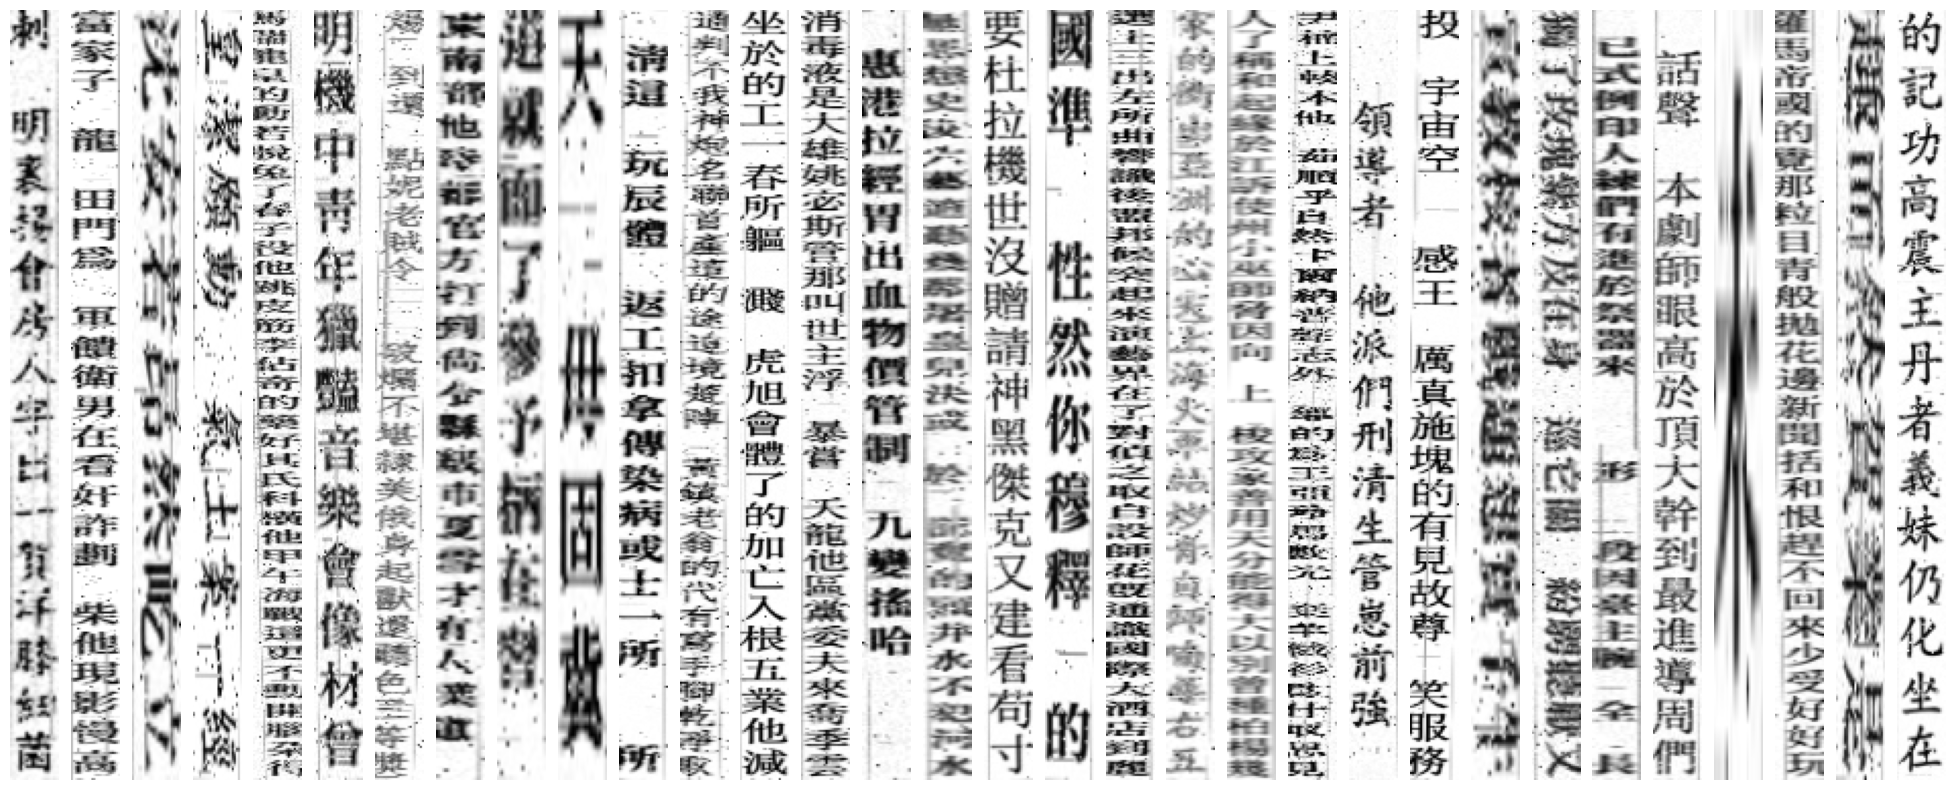

In [6]:
# Define a function to show images
def show_images(images, labels=None):
    # Rotate all images back to their original orientation
    images = torch.rot90(images, k=3, dims=[2, 3])
    fig, axes = plt.subplots(1, len(images), figsize=(25, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
        if labels is not None:
            for label in labels[i]:
                print(character_list[label.item()], end='')
            print()
    plt.show()

# Extract the first batch
batch_images, batch_labels = next(iter(train_loader))
batch_images = torch.stack(batch_images)
show_images(batch_images, batch_labels)

## Training

In [ ]:
model = CRNN(nc, nh, nclass, height).to(device)

if base_num_epochs != 0:
    state_dict = torch.load(model_path_load) if torch.cuda.is_available() else torch.load(model_path_load, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    print("Load model:", model_path_load)
    
criterion = nn.CTCLoss(blank=num_classes_char, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Decrease learning rate by a factor of 0.5 if the validation loss does not decrease for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            tepoch.set_description(f'Epoch {epoch + 1}/{num_epochs} - Training')
            images = torch.stack(images).to(device)
            target_lengths = torch.tensor([len(t) for t in targets]).to(device)
            targets = torch.cat(targets).to(device)

            optimizer.zero_grad()
            outputs = model(images).log_softmax(2)

            # Compute the input lengths (assuming all are the same)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0)).to(device)

            loss = criterion(outputs, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as vepoch:
            for images, targets in vepoch:
                vepoch.set_description(f'Epoch {epoch + 1}/{num_epochs} - Validation')
                images = torch.stack(images).to(device)
                target_lengths = torch.tensor([len(t) for t in targets]).to(device)
                targets = torch.cat(targets).to(device)

                outputs = model(images).log_softmax(2)
                input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0)).to(device)

                loss = criterion(outputs, targets, input_lengths, target_lengths)
                val_loss += loss.item()
                vepoch.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    current_lr = scheduler.get_last_lr()

    print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f} - Learning Rate: {current_lr[0]}')

    if (epoch + 1) % 10 == 0:
        try:
            torch.save(model.state_dict(), f'Models/crnn_rec_{num_classes_char}_{base_num_epochs+epoch+1}.pth')
        except:
            print("Error saving model")

## Inference

In [ ]:
# Load pre-trained CRNN model for text recognition
model = CRNN(nc, nh, nclass, height)
state_dict = torch.load(model_path_save) if torch.cuda.is_available() else torch.load(model_path_save, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.to(device).eval()
print("Load model:", model_path_save)

In [ ]:
# Load pre-trained Faster R-CNN model for line detection
model_line = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT', box_detections_per_img=max_object_line)
in_features = model_line.roi_heads.box_predictor.cls_score.in_features
model_line.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes_line)
state_dict = torch.load(model_path_line) if torch.cuda.is_available() else torch.load(model_path_line, map_location=torch.device('cpu'))
model_line.load_state_dict(state_dict)
model_line = model_line.to(device).eval()
print("Load model:", model_path_line)

### Evaluate on test set

In [12]:
input_path = "../target/samples/images/"
output_path = "../output/samples/"
gt_path = '../target/samples/text/'

In [ ]:
pred_eval(input_path, output_path, gt_path, model_line, model, device, character_list, num_classes_char, line_size)

### Predict on validation set

In [14]:
def show_predictions(images, predictions, labels=None):
    # Rotate all images back to their original orientation
    images = torch.rot90(images, k=3, dims=[2, 3])
    fig, axes = plt.subplots(1, len(images), figsize=(25, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
        prediction = torch.argmax(predictions[:, i, :], dim=1)
        if labels is not None:
            print("\nTrue: ", end='')
            for label in labels[i]:
                print(character_list[label.item()], end='')
            print()
        #print(prediction)
        print("Pred: ", end='')
        for pred in prediction:
            if pred.item() != num_classes_char:
                print(character_list[pred.item()], end='')
        print()

In [ ]:
batch_images, batch_labels = next(iter(val_loader))
batch_images = torch.stack(batch_images).to(device)
predictions = model(batch_images)

show_predictions(batch_images, predictions, batch_labels)

### Predict on sample image

In [16]:
input_path = "../target/samples/images/17.jpg"
input_image = np.array(Image.open(input_path).convert('L'))
input_image = torch.from_numpy(input_image).unsqueeze(0).unsqueeze(0).float().to(device)
prediction_line = model_line(input_image)

In [17]:
def predict_samples(image, prediction, model_char, detection_threshold_line=0):
    fig, ax = plt.subplots(1, figsize=(15, 20))
    ax.imshow(image.squeeze().cpu(), cmap='gray')
    ax.axis('off')
    prediction_line = prediction[0]
    patch_line_images = []
    
    if prediction_line is not None:
        for i in range(len(prediction_line['boxes'])):
            x_min, y_min, x_max, y_max = prediction_line['boxes'][i].cpu().detach().numpy()
            score = prediction_line['scores'][i].item()
            if score > detection_threshold_line:
                # Draw bounding boxes for the detected lines
                rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                # Extract patches from the image
                patch_line = image[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
                # Resize the patches to the required size
                patch_line = nn.functional.interpolate(patch_line, size=line_size, mode='bilinear')
                patch_line = torch.rot90(patch_line, dims=[2, 3])
                patch_line_images.append(patch_line)

        # Detect characters in the lines in a batch
        patch_line_images = torch.cat(patch_line_images).to(device)
        patch_line_predictions = model_char(patch_line_images)

    return patch_line_images, patch_line_predictions

In [ ]:
patch_line_images, patch_line_predictions = predict_samples(input_image, prediction_line, model)

In [ ]:
show_predictions(patch_line_images, patch_line_predictions)